## Notebook for PS2 (MACS-2017 Winter)

In [39]:
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy.optimize as opt
import numpy.linalg as lin
import scipy.integrate as intgr
import matplotlib
from matplotlib import cm
from numpy import exp as exp

%matplotlib notebook

# load the incomes data and sick data
data = np.loadtxt('incomes.txt')
sick = pd.read_csv('sick.txt', skiprows = 1, names = ['sick', 'age', 'children', 'avgtemp_winter'])



<IPython.core.display.Javascript object>


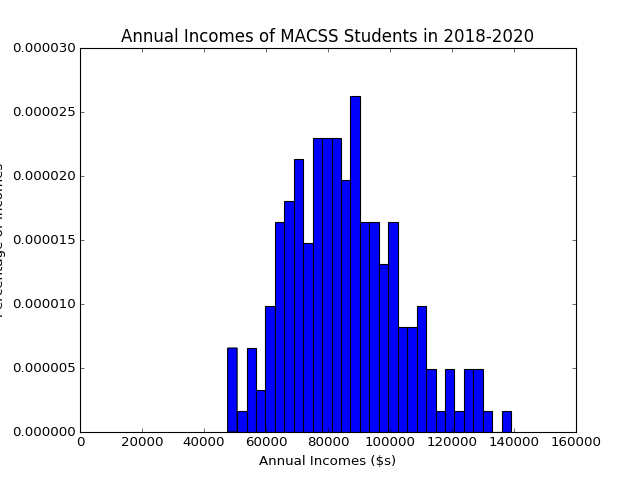

AttributeError: module 'matplotlib.pyplot' has no attribute 'yaxis'

In [100]:

num_bins = 30
# Plot the histogram for the annual incomes
fig, ax = plt.subplots()
# Plot the histogram for the annual incomes
count, bins, ignored = plt.hist(data, num_bins, normed=True)

# Label the plots
plt.title('Annual Incomes of MACSS Students in 2018-2020', fontsize=15)
plt.xlabel(r'Annual Incomes (\$s)')
plt.ylabel(r'Percentage of Incomes')

# Set the Limit of x-axis

plt.xlim([0,160000])


plt.yaxis.set_label_coords(1., 0.95)


1.(b)
mu_GMM1 = 11.3318808967  sig_GMM1 = 0.208696648842
Criterion value_GMM1 = [[  3.12965575e-15]]
Mean of data = 85276.8236063 , Variance of data = 323731572.23
Mean of model = 85276.8278958 , Variance of model = 323731564.303
Difference in mean = -0.0042894944927 Difference in variance = 7.9263535738
Error vector= [  5.03008240e-08  -2.44843390e-08]


<IPython.core.display.Javascript object>


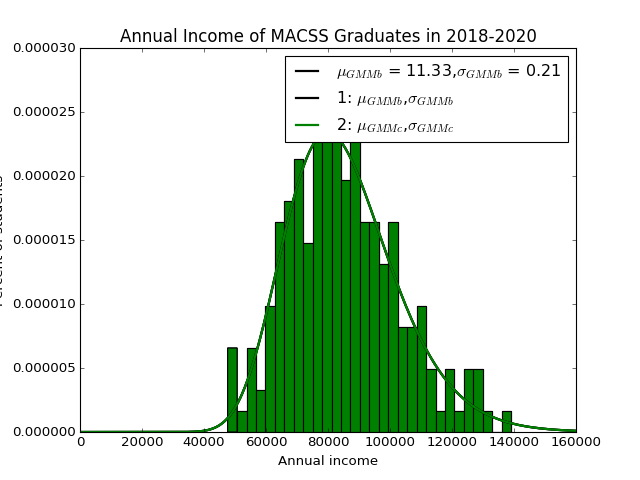

In [56]:
def lognorm_pdf(xvals, mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the lognormal pdf with mean mu and standard
    deviation sigma. If the cutoff is given, then the PDF values are
    inflated upward to reflect the zero probability on values above the
    cutoff. If there is no cutoff given, this function does the same
    thing as sp.stats.norm.pdf(x, loc=mu, scale=sigma).
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the lognormally distributed random
             variable
    mu     = scalar, mean of the lognormally distributed random variable
    sigma  = scalar > 0, standard deviation of the lognormally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    prob_notcut = scalar 
    pdf_vals = (N,) vector, normal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''
    if cutoff == 'None':
        prob_notcut = 1.0
    else:
        prob_notcut = sts.lognorm.cdf(cutoff, scale= np.exp(mu), s = sigma, loc = mu)
            
    pdf_vals    = ((1/(xvals*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals


def data_moments1(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), variance(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar, mean value of test scores data
    var_data  = scalar > 0, variance of test scores data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_data, var_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    var_data = xvals.var()
    
    return mean_data, var_data


def model_moments1(mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    This function computes the two model moments for GMM
    (mean(model data), variance(model data)).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        xfx()
        x2fx()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_model = scalar, mean value of test scores from model
    m_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the mean of the distribution
    var_model  = scalar > 0, variance of test scores from model
    v_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the variance of the distribution
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_model, var_model
    --------------------------------------------------------------------
    '''
    mean_model = exp(mu + ((sigma ** 2) / 2))
    var_model = (exp(sigma ** 2) - 1) * exp(2 * mu + sigma ** 2)
            
    
    return mean_model, var_model


def err_vec1(xvals, mu, sigma, cutoff, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments()
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    mean_data, var_data = data_moments1(xvals)
    moms_data = np.array([[mean_data], [var_data]])
    mean_model, var_model = model_moments1(mu, sigma, cutoff)
    moms_model = np.array([[mean_model], [var_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion1(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (2, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec1(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val



# Set up the initializing parameters
mu_init = 11
sig_init = 0.1
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)  # in the initial estimation
gmm_args = (data, 'None', W_hat)
results = opt.minimize(criterion1, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))

mu_GMM1, sig_GMM1 = results.x

print('1.(b)')
print('mu_GMM1 =', mu_GMM1, ' sig_GMM1 =', sig_GMM1)
print('Criterion value_GMM1 =', criterion1((mu_GMM1, sig_GMM1), data, np.inf, W_hat))

mean_data, var_data = data_moments1(data)
mean_model, var_model = model_moments1(mu_GMM1, sig_GMM1, np.inf)

err1 = err_vec1(data, mu_GMM1, sig_GMM1, np.inf, False).reshape(2,)
print('Mean of data =', mean_data, ', Variance of data =', var_data)
print('Mean of model =', mean_model, ', Variance of model =', var_model)
print('Difference in mean =', mean_data - mean_model, 'Difference in variance =', var_data - var_model)
print('Error vector=', err1)

#Plot the histogram of the data
count, bins, ignored = plt.hist(data, num_bins, normed=True)
plt.title('Annual Income of MACSS Graduates in 2018-2020', fontsize=15)
plt.xlabel(r'Annual Income')
plt.ylabel(r'Percent of Incomes')

# Plot the estimated GMM PDF
dist_pts = np.linspace(0, 160000, 500)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, np.inf),
        linewidth=2, color='k', label='$\mu_{GMMb}$ = 11.33,$\sigma_{GMMb}$ = 0.21')
plt.legend(loc='upper right')
        



1.(c)
mu_GMM2 = 11.3318796375  sig_GMM2 = 0.208696655465
Criterion value_GMM2 = [[ 0.36843184]]
Mean of data = 85276.8236063 , Variance of data = 323731572.23
Mean of model = 85276.7206263 , Variance of model = 323730770.861
Difference in mean = 0.102979999676 Difference in variance = 801.368354678


<IPython.core.display.Javascript object>


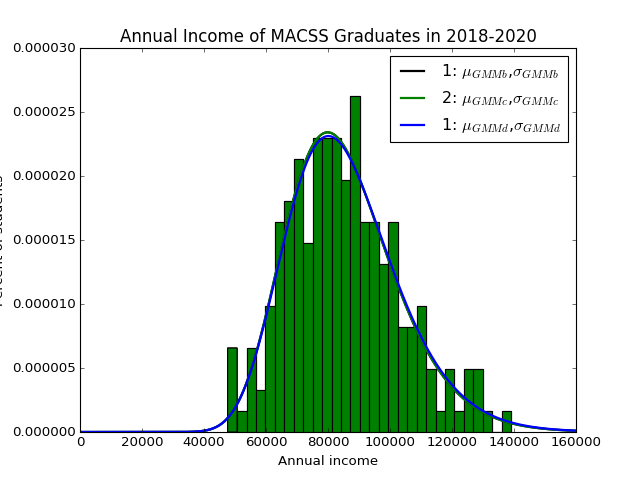

In [60]:
#1.c

err1 = err_vec1(data, mu_GMM1, sig_GMM1, np.inf, False)
VCV2 = np.dot(err1, err1.T) / data.shape[0]
# print(VCV2)
W_hat2 = lin.pinv(VCV2)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
# print(W_hat2)

mu_init = 11
sig_init = 0.1
params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args = (data, 'None', W_hat2)
results = opt.minimize(criterion1, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))

mu_GMM2, sig_GMM2 = results.x

print('1.(c)')
print('mu_GMM2 =', mu_GMM2, ' sig_GMM2 =', sig_GMM2)
print('Criterion value_GMM2 =', criterion1((mu_GMM2, sig_GMM2), data, np.inf, W_hat2))

mean_data, var_data = data_moments1(data)
mean_model, var_model = model_moments1(mu_GMM2, sig_GMM2, np.inf)
err = err_vec1(data, mu_GMM1, sig_GMM1, np.inf, False).reshape(2,)
print('Mean of data =', mean_data, ', Variance of data =', var_data)
print('Mean of model =', mean_model, ', Variance of model =', var_model)
print('Difference in mean =', mean_data - mean_model, 'Difference in variance =', var_data - var_model)

# Plot the histogram of the data
count, bins, ignored = plt.hist(data, num_bins, normed=True)
plt.title('Annual Income of MACSS Graduates in 2018-2020', fontsize=15)
plt.xlabel(r'Annual income')
plt.ylabel(r'Percent of students')

# Plot the estimated GMM PDF
dist_pts = np.linspace(0, 160000, 500)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, np.inf),
        linewidth=2, color='k', label='1: $\mu_{GMMb}$,$\sigma_{GMMb}$')
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM2, sig_GMM2, np.inf),
        linewidth=2, color='g', label='2: $\mu_{GMMc}$,$\sigma_{GMMc}$')
plt.legend(loc='upper right')



1.(d)
mu_GMM1_3= 11.3356810756  sig_GMM1_3= 0.210598873897
Criterion value_GMM1_3 = [[  1.45549442e-12]]
Moment1 of data = 0.3 , Moment2 of data = 0.5 Moment3 of data = 0.2
Moment1 of model = 0.3000007831688495 , Moment2 of model = 0.4999990909872008 Moment3 of model = 0.20000012584394972
Difference in moment1 = -7.831688494941424e-07 Difference in moment2 = 9.090127991995267e-07 Difference in moment3 = -1.2584394970538426e-07


<IPython.core.display.Javascript object>


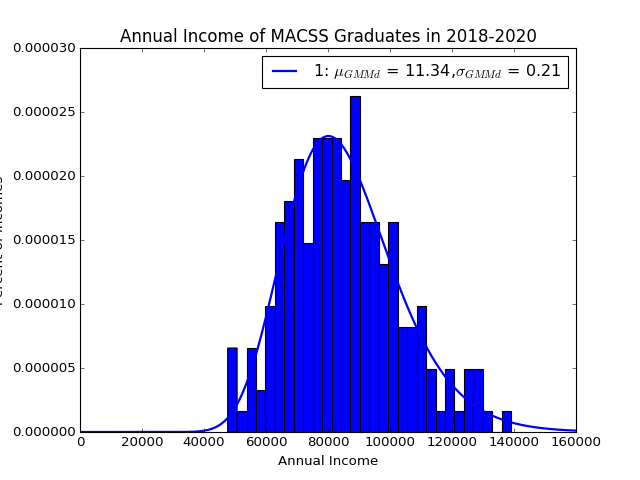

In [69]:
# 1-d)

def data_moments3(xvals):
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >= 75000) & (xvals < 100000)].shape[0] /
                xvals.shape[0])
    bpct_3_dat = xvals[xvals >= 100000].shape[0] / xvals.shape[0]
    
    return bpct_1_dat, bpct_2_dat, bpct_3_dat

def model_moments3(mu, sigma, cutoff):
    xfx = lambda x: lognorm_pdf(x, mu, sigma, cutoff)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 1e-10, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    # (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, np.inf)
    bpct_3_mod = 1 - bpct_1_mod - bpct_2_mod
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

def err_vec3(xvals, mu, sigma, cutoff, simple):
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma, cutoff)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    return err_vec

def criterion3(params, *args):
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec3(xvals, mu, sigma, cutoff, simple=True)
    crit_val = np.dot(np.dot(err.T, W), err)
    return crit_val

params_init = np.array([mu_init, sig_init])
W_hat = np.eye(3)
gmm_args = (data, np.inf, W_hat)
results_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
            method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1_3, sig_GMM1_3 = results_3.x

print('1.(d)')
print('mu_GMM1_3=', mu_GMM1_3, ' sig_GMM1_3=', sig_GMM1_3)
print('Criterion value_GMM1_3 =', criterion3((mu_GMM1_3, sig_GMM1_3), data, np.inf, W_hat))

moment1_data, moment2_data, moment3_data = data_moments3(data)
moment1_model, moment2_model, moment3_model = model_moments3(mu_GMM1_3, sig_GMM1_3, np.inf)
err1 = err_vec3(data, mu_GMM1_3, sig_GMM1_3, np.inf, True).reshape(3,)
print('Moment1 of data =', moment1_data, ', Moment2 of data =', moment2_data, 'Moment3 of data =', moment3_data)
print('Moment1 of model =', moment1_model, ', Moment2 of model =', moment2_model, 'Moment3 of model =', moment3_model)
print('Difference in moment1 =', moment1_data - moment1_model, 'Difference in moment2 =', moment2_data - moment2_model, 'Difference in moment3 =', moment3_data - moment3_model)

# Plot the histogram of the data
count, bins, ignored = plt.hist(data, num_bins, normed=True)
plt.title('Annual Income of MACSS Graduates in 2018-2020', fontsize=15)
plt.xlabel(r'Annual Income')
plt.ylabel(r'Percent of Incomes')

# Plot the estimated GMM PDF
dist_pts = np.linspace(0, 160000, 500)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM1_3, sig_GMM1_3, np.inf),
        linewidth=2, color='b', label='1: $\mu_{GMMd}$ = 11.34,$\sigma_{GMMd}$ = 0.21')
plt.legend(loc='upper right')

1.(e)
mu_GMM2_3= 11.3356815244  sig_GMM2_3= 0.210598561303
Criterion value_GMM2_3 = [[  6.26968169e-05]]
Moment1 of data = 0.3 , Moment2 of data = 0.5 Moment3 of data = 0.2
Moment1 of model = 0.29999977157528535 , Moment2 of model = 0.4999998556956539 Moment3 of model = 0.20000037272906074
Difference in moment1 = 2.2842471464334935e-07 Difference in moment2 = 1.4430434608359022e-07 Difference in moment3 = -3.7272906072693957e-07


<IPython.core.display.Javascript object>


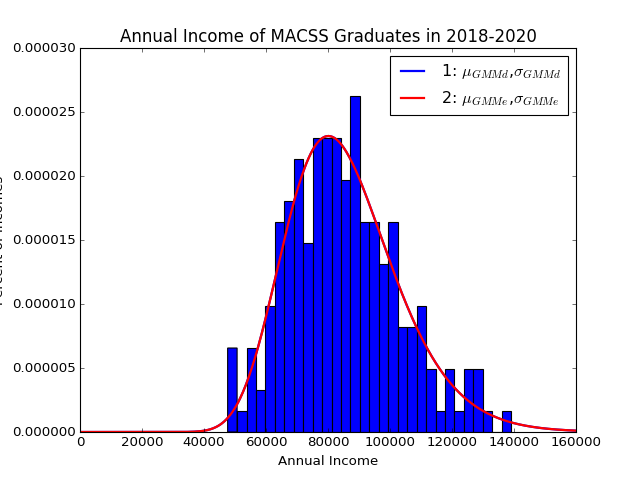

In [70]:
# set up the 2-step W matrix
err1 = err_vec3(data, mu_GMM1_3, sig_GMM1_3, np.inf, True)
VCV2 = np.dot(err1, err1.T) /data.shape[0]
W_hat2 = lin.pinv(VCV2) 


params_init = np.array([mu_GMM1_3, sig_GMM1_3])
gmm_args = (data, np.inf, W_hat2)
results = opt.minimize(criterion3, params_init, args=(gmm_args),
                        method='TNC',
                        bounds=((1e-10, None), (1e-10, None)))
mu_GMM2_3, sig_GMM2_3 = results.x

# Print the results
print('1.(e)')
print('mu_GMM2_3=', mu_GMM2_3, ' sig_GMM2_3=', sig_GMM2_3)
print('Criterion value_GMM2_3 =', criterion3((mu_GMM2_3, sig_GMM2_3), data, np.inf, W_hat2))
moment1_data, moment2_data, moment3_data = data_moments3(data)
moment1_model, moment2_model, moment3_model = model_moments3(mu_GMM2_3, sig_GMM2_3, np.inf)
err1 = err_vec3(data, mu_GMM2_3, sig_GMM2_3, np.inf, True).reshape(3,)

print('Moment1 of data =', moment1_data, ', Moment2 of data =', moment2_data, 'Moment3 of data =', moment3_data)
print('Moment1 of model =', moment1_model, ', Moment2 of model =', moment2_model, 'Moment3 of model =', moment3_model)
print('Difference in moment1 =', moment1_data - moment1_model, 'Difference in moment2 =', moment2_data - moment2_model, 'Difference in moment3 =', moment3_data - moment3_model)

# Plot the histogram of the data
count, bins, ignored = plt.hist(data, num_bins, normed=True)
plt.title('Annual Income of MACSS Graduates in 2018-2020', fontsize=15)
plt.xlabel(r'Annual Income')
plt.ylabel(r'Percent of Incomes')

# Plot the estimated GMM PDF
dist_pts = np.linspace(0, 160000, 500)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM1_3, sig_GMM1_3, np.inf),
        linewidth=2, color='b', label='1: $\mu_{GMMd}$,$\sigma_{GMMd}$')
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM2_3, sig_GMM2_3, np.inf),
         linewidth=2, color='r', label='2: $\mu_{GMMe}$,$\sigma_{GMMe}$')
plt.legend(loc='upper right')




<IPython.core.display.Javascript object>


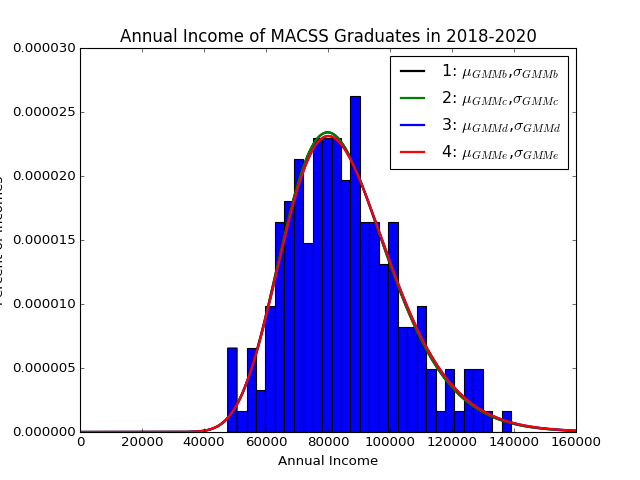

In [72]:
#1-f
# Plot the histogram of the data
count, bins, ignored = plt.hist(data, num_bins, normed=True)
plt.title('Annual Income of MACSS Graduates in 2018-2020', fontsize=15)
plt.xlabel(r'Annual Income')
plt.ylabel(r'Percent of Incomes')

# Plot the estimated GMM PDF
dist_pts = np.linspace(0, 160000, 500)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, np.inf),
        linewidth=2, color='k', label='1: $\mu_{GMMb}$,$\sigma_{GMMb}$')
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM2, sig_GMM2, np.inf),
        linewidth=2, color='g', label='2: $\mu_{GMMc}$,$\sigma_{GMMc}$')
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM1_3, sig_GMM1_3, np.inf),
        linewidth=2, color='b', label='3: $\mu_{GMMd}$,$\sigma_{GMMd}$')
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM2_3, sig_GMM2_3, np.inf),
         linewidth=2, color='r', label='4: $\mu_{GMMe}$,$\sigma_{GMMe}$')
plt.legend(loc='upper right')

In [92]:
sick = pd.read_csv('sick.txt', skiprows = 1, names = ['sick', 'age', 'children', 'avgtemp_winter'])

def data_moments2(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the error terms of the linear data
    --------------------------------------------------------------------
    '''
    return sick['sick']


def model_moments2(xvals, b0, b1, b2, b3):
    '''
    --------------------------------------------------------------------
    This function computes the model moments for GMM
    (estimated sick value).
    --------------------------------------------------------------------
    
    '''
    result = b0 + b1 * sick['age'] + b2 * sick['children'] + b3 * sick['avgtemp_winter']
    return result


def err_vec2(xvals, b0, b1, b2, b3, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    '''
    moms_data = np.array(data_moments2(xvals))
    moms_model = np.array(model_moments2(xvals, b0, b1, b2, b3))
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    return err_vec
    


def criterion2(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    
    --------------------------------------------------------------------
    '''
    b0, b1, b2, b3 = params
    xvals, W = args
    err = err_vec2(xvals, b0, b1, b2, b3, simple = True )
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

b0_init, b1_init, b2_init, b3_init = (0, 0, 0, 1)
params_init = np.array([b0_init, b1_init, b2_init, b3_init])
W_hat = np.eye (200)
gmm_args = (sick, W_hat)
results = opt.minimize(criterion2, params_init, args=(gmm_args),
                       method='L-BFGS-B')

b0_GMM1, b1_GMM1, b2_GMM1, b3_GMM1 = results.x
print('2.(a)')
print('b0_GMM1=', b0_GMM1, 'b1_GMM1=', b1_GMM1,'b2_GMM1=', b2_GMM1, 'b3_GMM1=', b3_GMM1)
print('criterion_GMM1=',criterion2((b0_GMM1, b1_GMM1, b2_GMM1, b3_GMM1), sick, W_hat))






2.(a)
b0_GMM1= 0.2516448071 b1_GMM1= 0.0129334339724 b2_GMM1= 0.400501320985 b3_GMM1= -0.00999168730293
criterion_GMM1= 0.00182128984298


In [80]:

sick['sick']

0      1.67
1      0.71
2      1.39
3      1.37
4      1.45
5      0.62
6      1.06
7      1.29
8      1.05
9      1.18
10     1.21
11     0.63
12     0.67
13     0.64
14     0.86
15     1.25
16     0.88
17     0.12
18     1.53
19     1.36
20     0.73
21     0.15
22     0.60
23     1.28
24     0.89
25     0.46
26     1.03
27     0.42
28     0.60
29     1.86
       ... 
170    0.91
171    0.60
172    1.14
173    1.15
174    0.73
175    0.93
176    0.88
177    1.13
178    0.69
179    1.23
180    0.38
181    1.23
182    1.03
183    1.76
184    0.90
185    0.32
186    0.63
187    1.56
188    1.06
189    1.16
190    0.34
191    0.33
192    1.98
193    0.61
194    1.00
195    0.53
196    0.86
197    1.39
198    0.72
199    1.29
Name: sick, dtype: float64